In [1]:

import os
import pandas as pd
import cv2
import time
from glob import glob
from tqdm import tqdm
import numpy as np 
import cv2 as cv
import zipfile
import io
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
from sklearn.impute import SimpleImputer
import albumentations
from sklearn.model_selection import train_test_split
from scipy.ndimage.morphology import binary_dilation
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
from pathlib import Path
import matplotlib.patches as patches
from PIL import Image

# You can use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass

warnings.warn = warn
warnings.filterwarnings('ignore')



/home/mp/viscode-github/DLFromScratch/.venv/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/tmp/ipykernel_7039/1654796537.py:21: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import binary_dilation


In [2]:
label_names = ['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive']
#label_names = ['elbow positive', 'fingers positive', 'forearm fracture', 'humerus', 'shoulder fracture', 'wrist positive']


In [3]:
# Train:
# 3631 samples, 306 elbow, 317 fingers, 289 forearm, 287 humerus, 333 shoulder, 291 wrist
# Eval:
# 348 samples, 28 elbow, 32 ingers, 38 forearm, 32 humerus, 18 shoulder, 28 wrist
# Test:
# 169 samples, 13 elbow, 16 ingers, 12 forearm, 9 humerus, 20 shoulder, 14 wrist


In [4]:

import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from glob import glob
from torchvision import tv_tensors
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define the augmentation pipeline
def get_augmentation_pipeline():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.5),
        #A.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05, p=0.5),
        #A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2),
        A.Normalize(mean=(0.5,), std=(0.5,)),
        ToTensorV2()],
        bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
    )

class BoneFractureDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_paths = sorted(glob(os.path.join(image_dir, '*.jpg')))
        self.label_paths = sorted(glob(os.path.join(label_dir, '*.txt')))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        #print('index:', idx)
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        image = Image.open(image_path).convert("RGB")
        original_width, original_height = image.size
        image = np.array(image)

        #print(f'Image shape before: {image.shape}')
        
        boxes = []
        labels = []

        with open(label_path, 'r') as file:
            for line in file:
                parts = line.strip().split()
                class_id = int(parts[0])
                if class_id == 3:
                    continue
                # elif class_id > 3:
                #     class_id -= 1
                coords = [float(x) for x in parts[1:]]
                #print(f'coords: {coords}')

                # Extract the x and y coordinates
                x_coords = coords[0::2]
                y_coords = coords[1::2]

                # Convert from normalized coordinates to pixel coordinates
                x_coords = [x * original_width for x in x_coords]
                y_coords = [y * original_height for y in y_coords]

                # Find the min and max coordinates to form the bounding box
                x_min = min(x_coords)
                y_min = min(y_coords)
                x_max = max(x_coords)
                y_max = max(y_coords)

                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(class_id)
        
        # Convert the bounding box coordinates to the format expected by the model

        boxes = np.array(boxes)
        
        if self.transform:
            augmented = self.transform(image=image, bboxes=boxes, labels=labels)
            image = augmented['image']
            boxes = augmented['bboxes']
            labels = augmented['labels']

            #print(f'Image shape after: {image.shape}')
            
            new_width, new_height = image.shape[2], image.shape[1]  # Get the new width and height from the transformed image

            # Scale the bounding boxes to the new image size
            scale_x = new_width / original_width
            scale_y = new_height / original_height
            boxes = [[x_min * scale_x, y_min * scale_y, x_max * scale_x, y_max * scale_y] for x_min, y_min, x_max, y_max in boxes]
        
        if len(boxes) == 0:
            # If there are no bounding boxes, create an empty tensor
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)

        if len(labels) > len(boxes):
            labels = labels[:len(boxes)]


        boxes = torch.tensor(boxes, dtype=torch.float32)
 
        labels = torch.tensor(labels, dtype=torch.int64)

        image_id = torch.tensor([idx])

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) if len(boxes) > 0 else torch.tensor([0], dtype=torch.float32)
        if len(area) > len(boxes):
            area = area[:len(boxes)]

        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        return image, target


train_image_dir = '/home/mp/.cache/kagglehub/datasets/pkdarabi/bone-fracture-detection-computer-vision-project/versions/2/bone fracture detection.v4-v4.yolov8/train/images'
train_label_dir = '/home/mp/.cache/kagglehub/datasets/pkdarabi/bone-fracture-detection-computer-vision-project/versions/2/bone fracture detection.v4-v4.yolov8/train/labels'
transform = get_augmentation_pipeline()

# Split the dataset into train and eval sets
train_image_paths = sorted(glob(os.path.join(train_image_dir, '*.jpg')))
train_label_paths = sorted(glob(os.path.join(train_label_dir, '*.txt')))


# Create train and eval datasets
train_dataset = BoneFractureDataset(image_dir=train_image_dir, label_dir=train_label_dir, transform=transform)


eval_image_dir = '/home/mp/.cache/kagglehub/datasets/pkdarabi/bone-fracture-detection-computer-vision-project/versions/2/bone fracture detection.v4-v4.yolov8/valid/images'
eval_label_dir = '/home/mp/.cache/kagglehub/datasets/pkdarabi/bone-fracture-detection-computer-vision-project/versions/2/bone fracture detection.v4-v4.yolov8/valid/labels'


eval_dataset = BoneFractureDataset(image_dir=eval_image_dir, label_dir=eval_label_dir, transform=transform)



#train_dataset = BoneFractureDataset(image_dir=train_image_dir, label_dir=train_label_dir, transform=transform)

#train_dataset, eval_dataset = train_test_split(train_dataset, test_size=0.2, random_state=42)




557.3927001953125 392.1655578613281 659.6000366210938 500.99713134765625


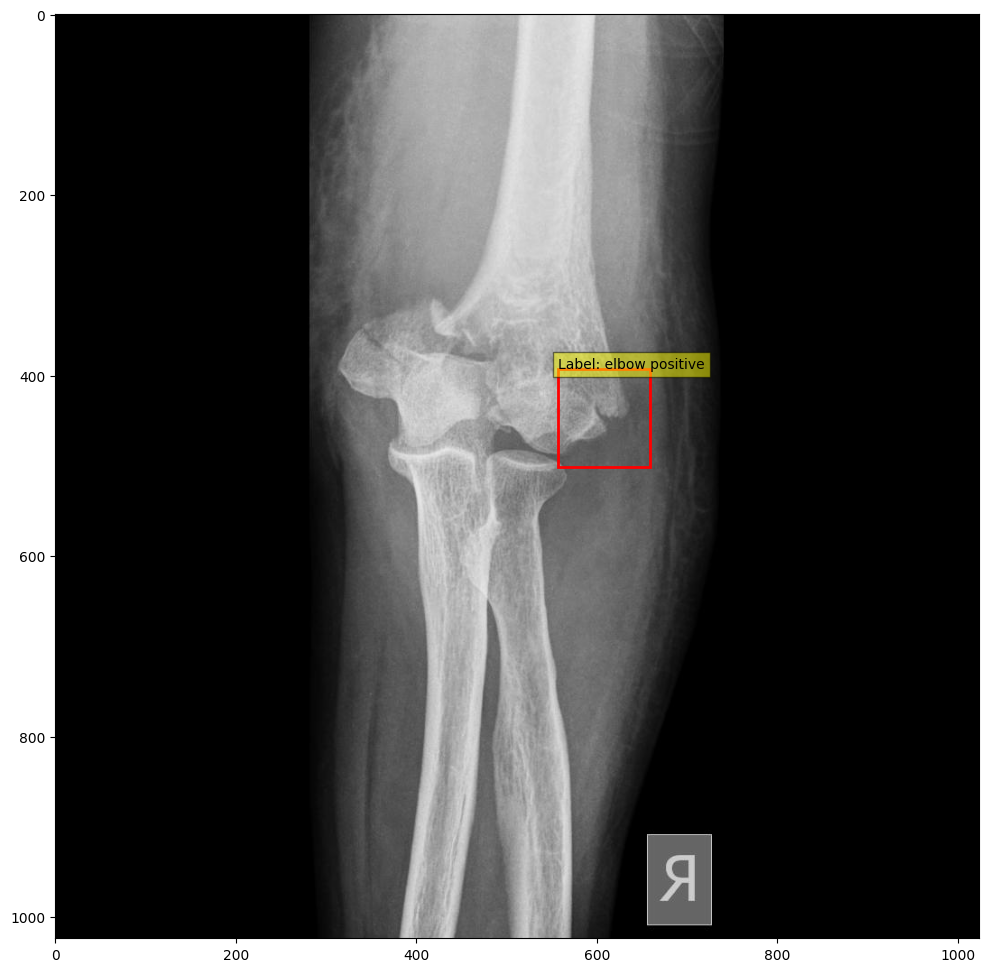

411.7171630859375 350.7262268066406 512.0048828125 455.20709228515625


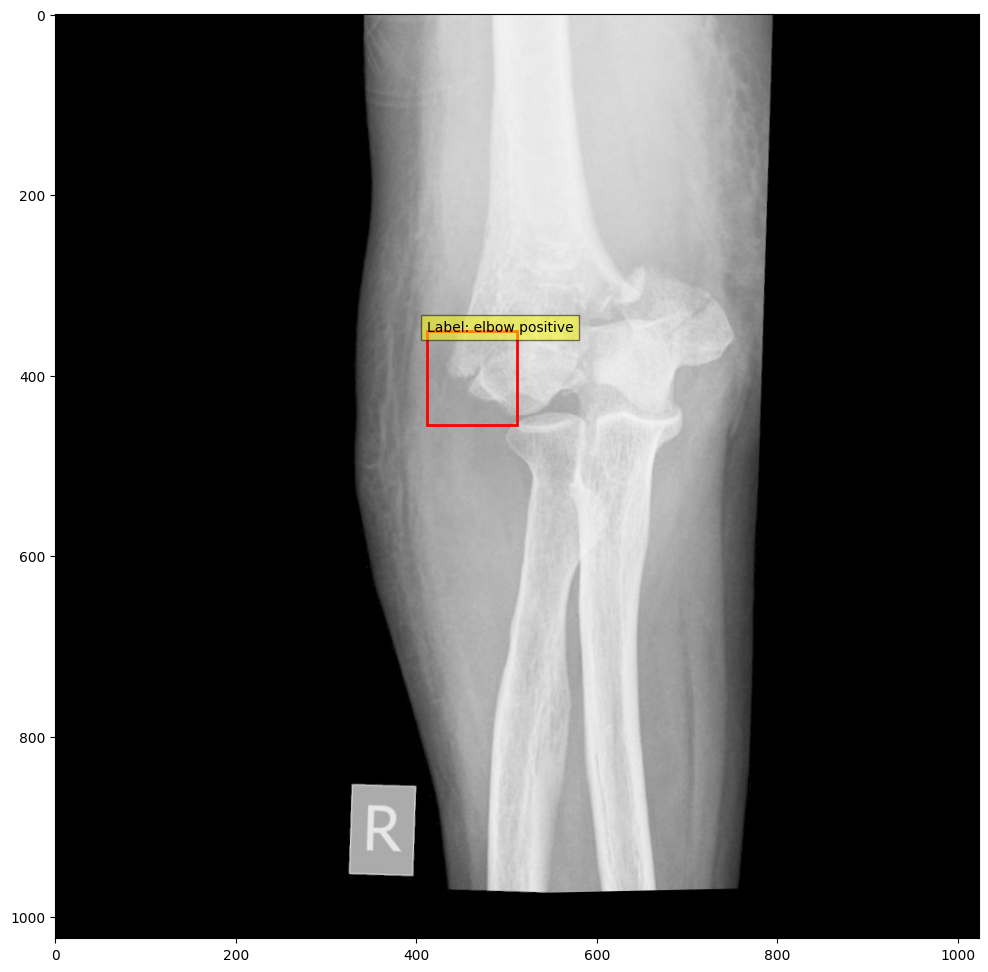

334.5286865234375 345.8155517578125 439.416748046875 450.32696533203125


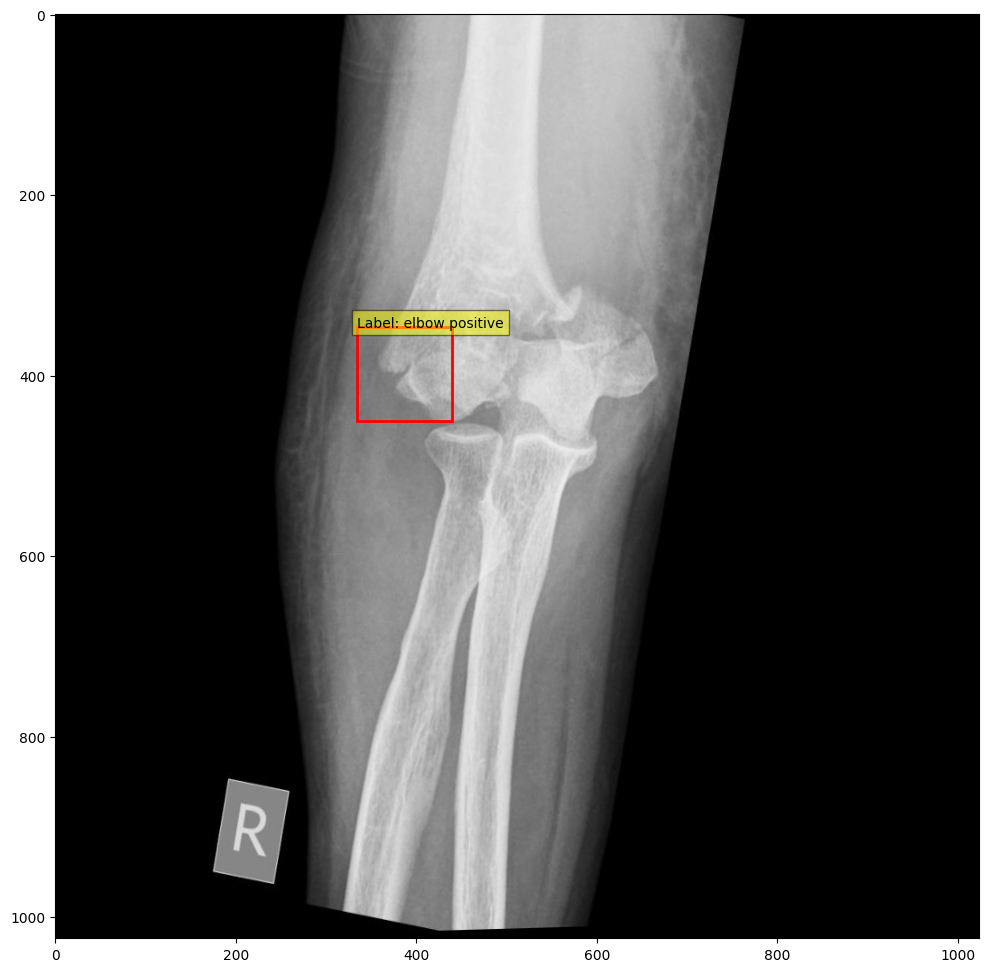

741.0910034179688 812.963623046875 1263.5552978515625 1448.6842041015625


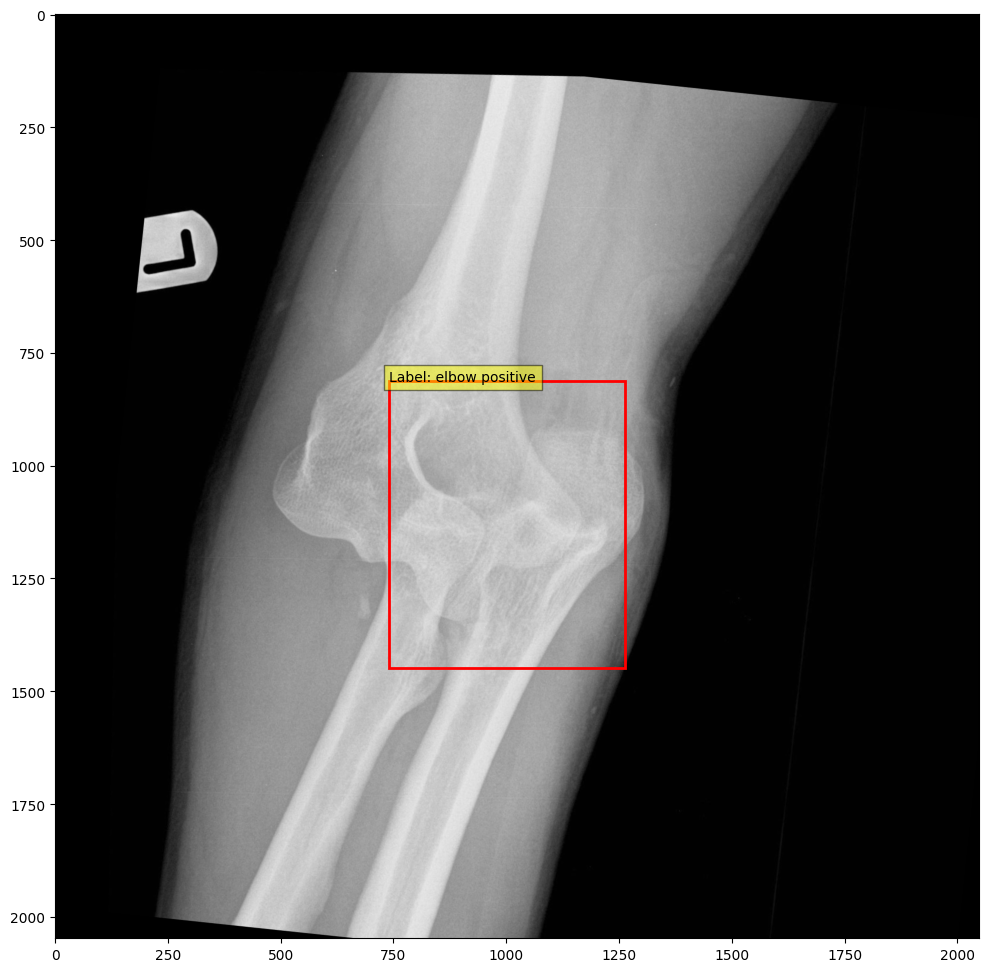

648.7435913085938 753.6752319335938 1143.742919921875 1341.5328369140625


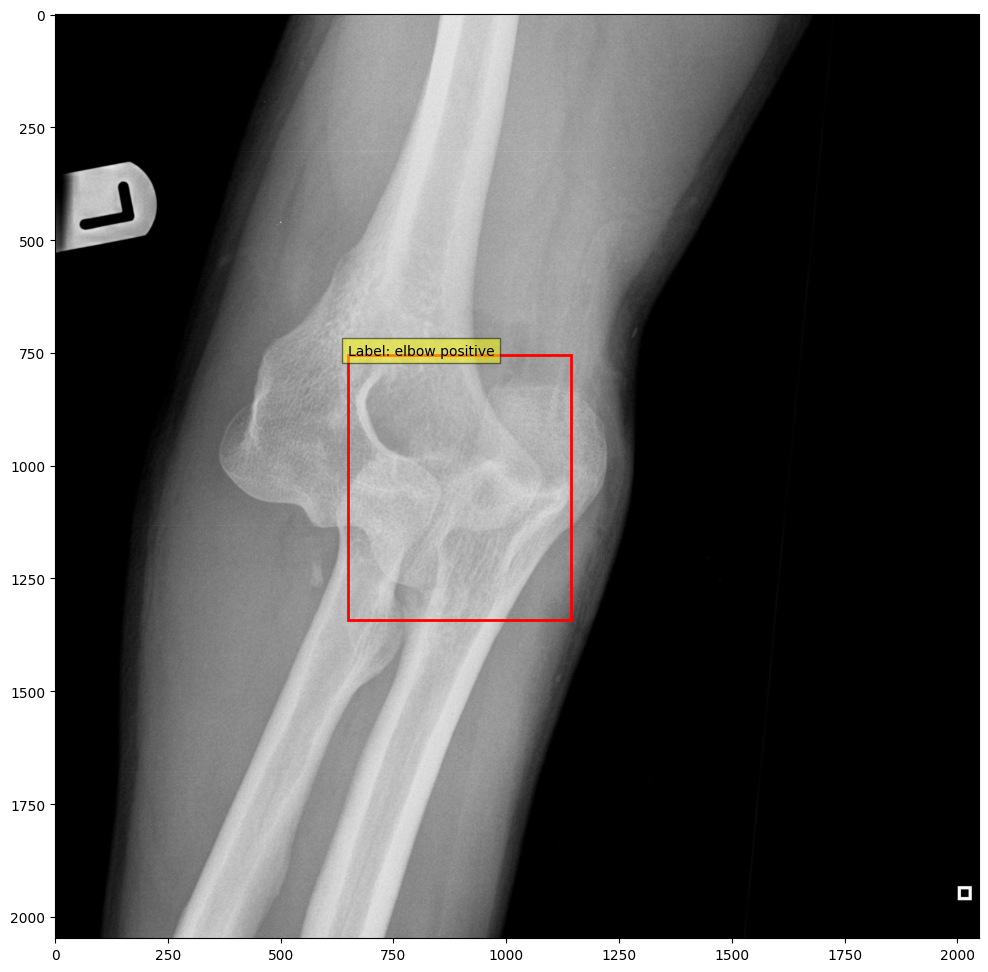

841.3213500976562 813.0543212890625 1437.8367919921875 1458.4052734375


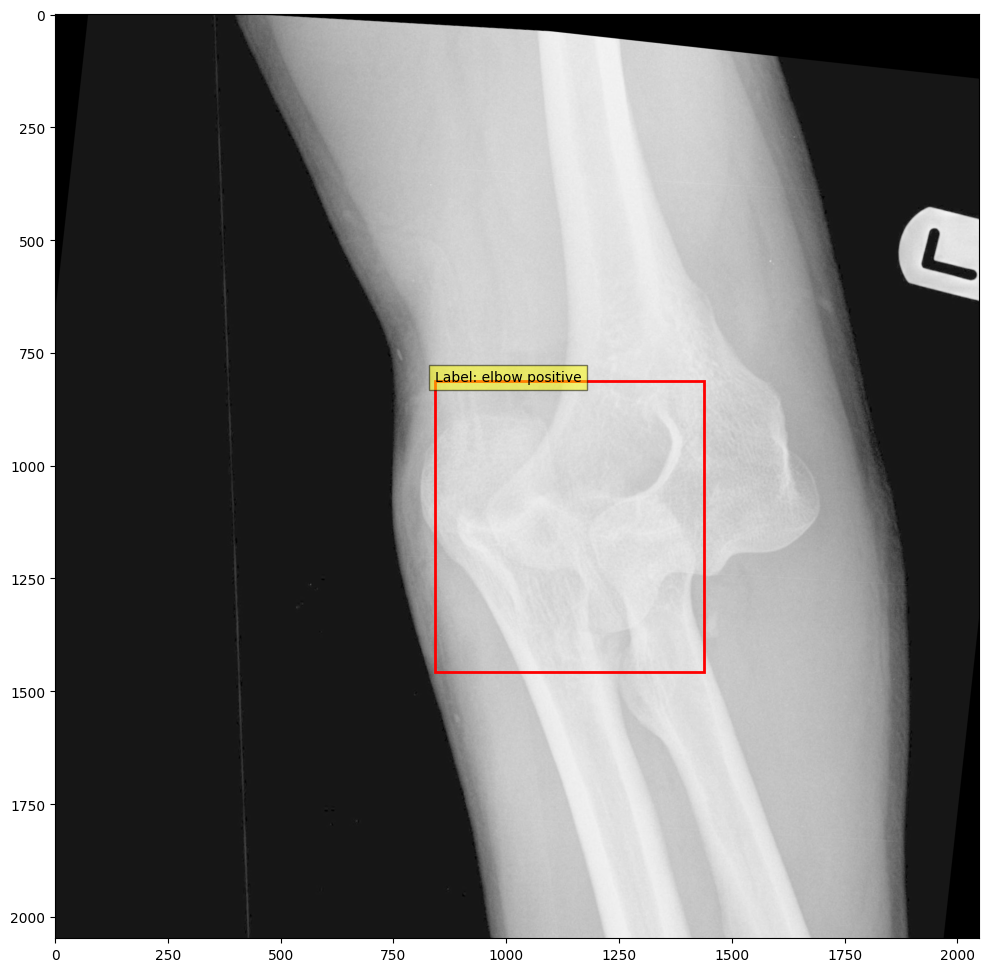

425.2525939941406 1029.802734375 667.6297607421875 1255.215576171875


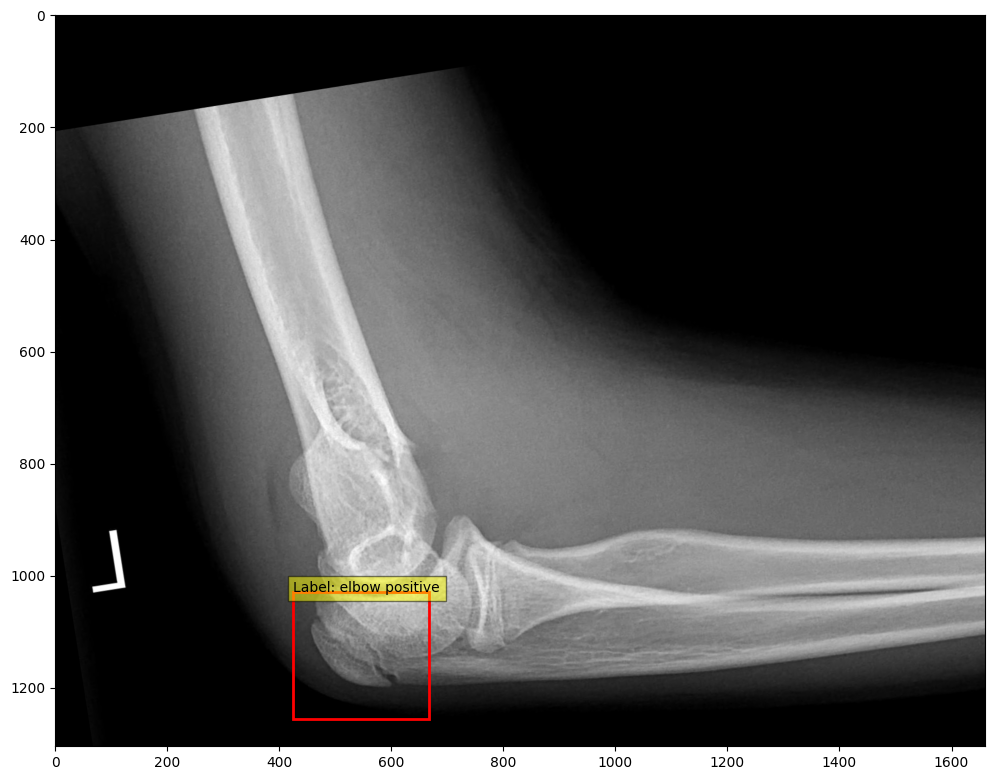

416.20782470703125 1002.8807983398438 653.2728881835938 1220.3155517578125


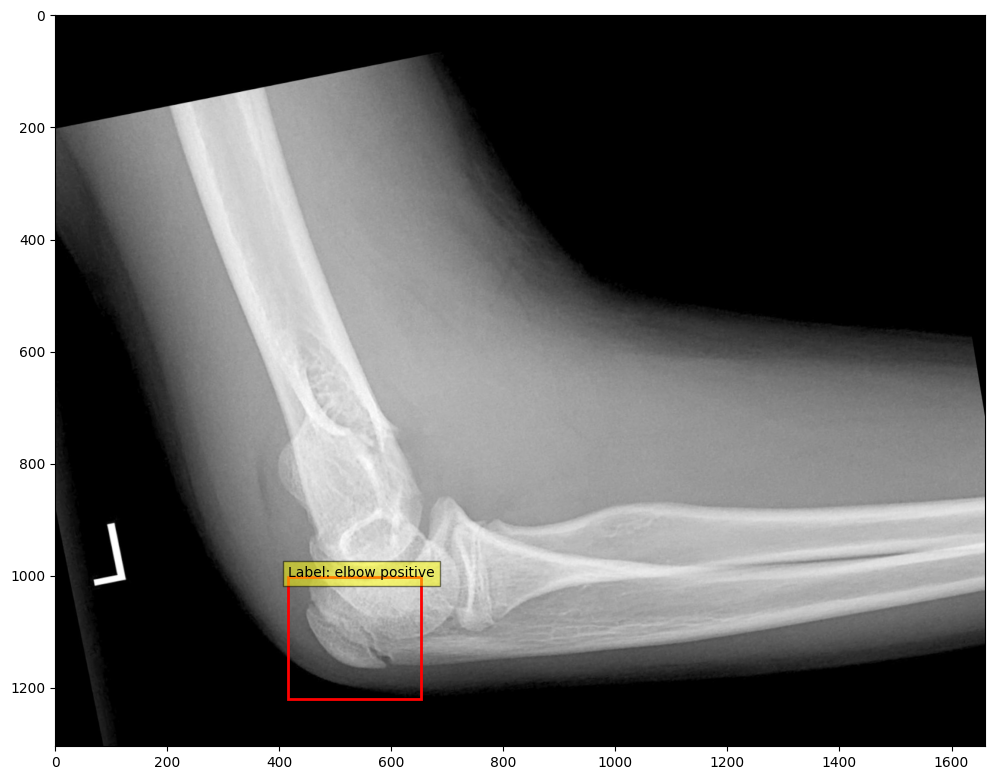

1085.7037353515625 928.8457641601562 1290.0670166015625 1131.9444580078125


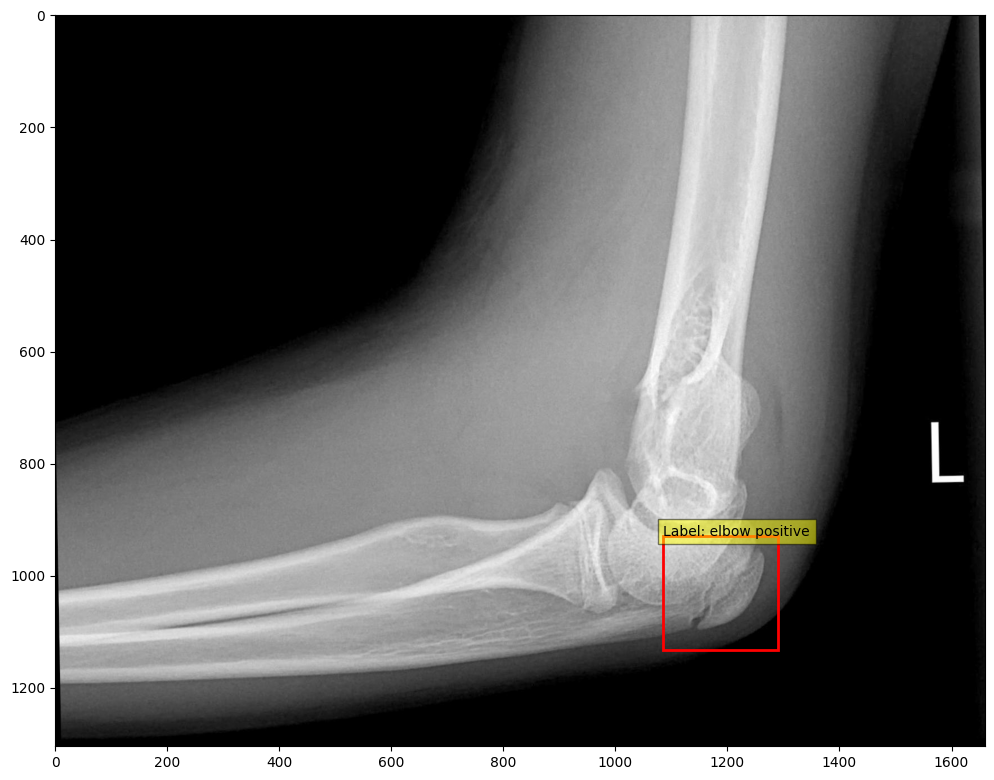

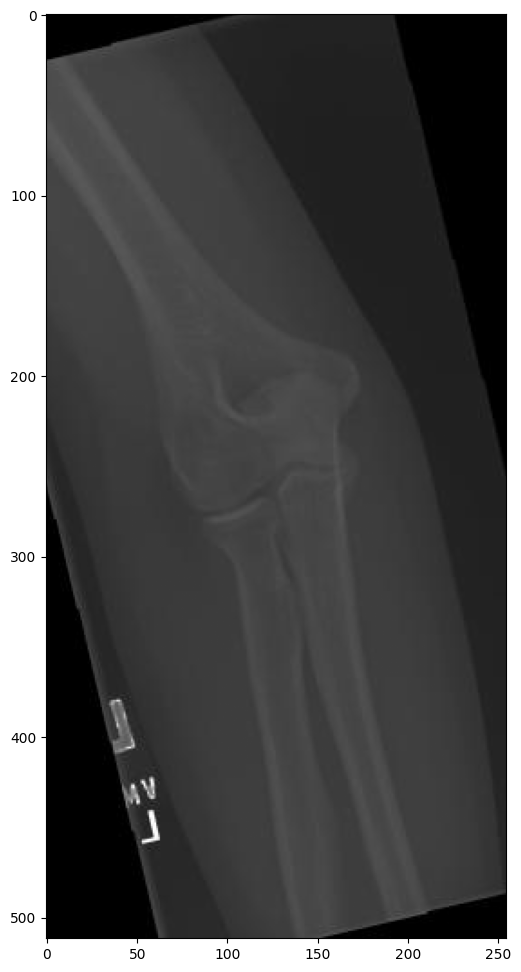

In [5]:
# plot images with labels

import matplotlib.pyplot as plt
import matplotlib.patches as patches

mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

def denormalize(image, mean, std):
    """
    Denormalize a normalized image.

    Parameters:
        image (torch.Tensor): The normalized image tensor (C, H, W).
        mean (list): The mean used for normalization.
        std (list): The standard deviation used for normalization.

    Returns:
        torch.Tensor: The denormalized image tensor.
    """
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return image * std + mean

def plot_images_with_labels(dataset, num_images=5):
    """
    Plots images with their bounding boxes and labels from the given dataset.

    Args:
        dataset: The dataset containing images and labels.
        num_images: Number of images to plot.
    """
    for i in range(num_images):
        image, target = dataset[i]
        # Denormalize the image
        denormalized_image = denormalize(image, mean, std)

        # Convert to numpy and transpose for imshow
        image_np = denormalized_image.permute(1, 2, 0).numpy()

        # Clip values to [0, 1] for float images
        image_np = np.clip(image_np, 0, 1)
        fig, ax = plt.subplots(1, figsize=(12, 12))
        ax.imshow(image_np)

        # Plot bounding boxes
        for box, label in zip(target['boxes'], target['labels']):
            x_min, y_min, x_max, y_max = box.tolist()  # Convert tensor to list
            print(x_min, y_min, x_max, y_max)
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            label = int(label.item())
            # if label > 3:
            #     label -=1
            ax.text(x_min, y_min, f'Label: {label_names[label]}', bbox=dict(facecolor='yellow', alpha=0.5))

        plt.show()

# Example usage
plot_images_with_labels(train_dataset, num_images=10)

In [6]:
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
device = 'cuda'
# # load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# # replace the classifier with a new one, that has
# # num_classes which is user-defined
num_classes = 7
# # get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# # replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [7]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4, collate_fn=collate_fn)
eval_dataloader = DataLoader(eval_dataset, batch_size=8, shuffle=True, num_workers=4, collate_fn=collate_fn)
#next(iter(eval_dataloader))

In [8]:
from torchvision.ops import box_iou

def evaluate_bounding_boxes_with_classes(model, dataloader, device):
    model.eval()
    total_iou = 0
    total_boxes = 0
    all_iou_scores = []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc='Evaluating', unit='batch'):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for target, output in zip(targets, outputs):
                gt_boxes = target['boxes']
                gt_labels = target['labels']
                pred_boxes = output['boxes']
                pred_labels = output['labels']

                if len(gt_boxes) == 0 or len(pred_boxes) == 0:
                    continue

                # Filter predictions by matching classes
                for gt_box, gt_label in zip(gt_boxes, gt_labels):
                    matching_indices = (pred_labels == gt_label).nonzero(as_tuple=True)[0]
                    if len(matching_indices) > 0:
                        matching_pred_boxes = pred_boxes[matching_indices]
                        iou_scores = box_iou(gt_box.unsqueeze(0), matching_pred_boxes)
                        max_iou_score = iou_scores.max().item()
                        all_iou_scores.append(max_iou_score)
                        total_iou += max_iou_score
                        total_boxes += 1

    avg_iou = total_iou / total_boxes if total_boxes > 0 else 0
    return avg_iou, all_iou_scores



In [9]:
# Evaluate the model on the evaluation dataset
avg_iou, all_iou_scores = evaluate_bounding_boxes_with_classes(model, eval_dataloader, device)

# Print the results
print(f"Average IoU: {avg_iou:.4f}")
print(f"Number of IoU scores: {len(all_iou_scores)}")

Evaluating: 100%|██████████| 44/44 [00:10<00:00,  4.17batch/s]

Average IoU: 0.0250
Number of IoU scores: 100


In [10]:
# # # Load the model checkpoint
# checkpoint_path = "best_model_epoch_72.pth"
# model.load_state_dict(torch.load(checkpoint_path))
#  # Set the model to evaluation mode

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: zedzeall47 (zedzeall47-spotr) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.73batch/s]


Average IoU: 0.3758
Model saved at epoch 1 with IoU: 0.3758
Epoch [1/40], Loss: 0.2847


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.60batch/s]


Average IoU: 0.5243
Model saved at epoch 2 with IoU: 0.5243
Epoch [2/40], Loss: 0.2375


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.63batch/s]


Average IoU: 0.5123
Epoch [3/40], Loss: 0.2197


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.58batch/s]


Average IoU: 0.4848
Epoch [4/40], Loss: 0.1961


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.66batch/s]


Average IoU: 0.4993
Epoch [5/40], Loss: 0.1815


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.65batch/s]


Average IoU: 0.4922
Epoch [6/40], Loss: 0.1539


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.70batch/s]


Average IoU: 0.4931
Epoch [7/40], Loss: 0.1397


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.67batch/s]


Average IoU: 0.4560
Epoch [8/40], Loss: 0.1357


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.59batch/s]


Average IoU: 0.4619
Epoch [9/40], Loss: 0.1273


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.65batch/s]


Average IoU: 0.4699
Epoch [10/40], Loss: 0.1051


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.71batch/s]


Average IoU: 0.4448
Epoch [11/40], Loss: 0.1239


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.67batch/s]


Average IoU: 0.4763
Epoch [12/40], Loss: 0.1169


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.62batch/s]


Average IoU: 0.4794
Epoch [13/40], Loss: 0.1103


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.62batch/s]


Average IoU: 0.4239
Epoch [14/40], Loss: 0.1074


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.61batch/s]


Average IoU: 0.3935
Epoch [15/40], Loss: 0.0918


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.65batch/s]


Average IoU: 0.3934
Epoch [16/40], Loss: 0.0996


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.77batch/s]


Average IoU: 0.4244
Epoch [17/40], Loss: 0.1213


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.67batch/s]


Average IoU: 0.4506
Epoch [18/40], Loss: 0.1232


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.60batch/s]


Average IoU: 0.4313
Epoch [19/40], Loss: 0.1081


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.55batch/s]


Average IoU: 0.4134
Epoch [20/40], Loss: 0.1030


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.66batch/s]


Average IoU: 0.4070
Epoch [21/40], Loss: 0.0903


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.61batch/s]


Average IoU: 0.4177
Epoch [22/40], Loss: 0.0748


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.63batch/s]


Average IoU: 0.4163
Epoch [23/40], Loss: 0.0737


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.55batch/s]


Average IoU: 0.4056
Epoch [24/40], Loss: 0.0721


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.61batch/s]


Average IoU: 0.4380
Epoch [25/40], Loss: 0.0732


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.54batch/s]


Average IoU: 0.4134
Epoch [26/40], Loss: 0.0647


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.62batch/s]


Average IoU: 0.4238
Epoch [27/40], Loss: 0.0587


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.74batch/s]


Average IoU: 0.4175
Epoch [28/40], Loss: 0.0572


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.65batch/s]


Average IoU: 0.4466
Epoch [29/40], Loss: 0.0578


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.67batch/s]


Average IoU: 0.4118
Epoch [30/40], Loss: 0.0549


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.67batch/s]


Average IoU: 0.4343
Epoch [31/40], Loss: 0.0483


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.71batch/s]


Average IoU: 0.4324
Epoch [32/40], Loss: 0.0470


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.64batch/s]


Average IoU: 0.3869
Epoch [33/40], Loss: 0.0541


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.72batch/s]


Average IoU: 0.4150
Epoch [34/40], Loss: 0.0588


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.59batch/s]


Average IoU: 0.4350
Epoch [35/40], Loss: 0.0583


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.59batch/s]


Average IoU: 0.4175
Epoch [36/40], Loss: 0.0604


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.57batch/s]


Average IoU: 0.4063
Epoch [37/40], Loss: 0.0551


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.64batch/s]


Average IoU: 0.4433
Epoch [38/40], Loss: 0.0548


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.62batch/s]


Average IoU: 0.4334
Epoch [39/40], Loss: 0.0564


Evaluating: 100%|██████████| 44/44 [00:09<00:00,  4.57batch/s]


Average IoU: 0.4074
Epoch [40/40], Loss: 0.0538


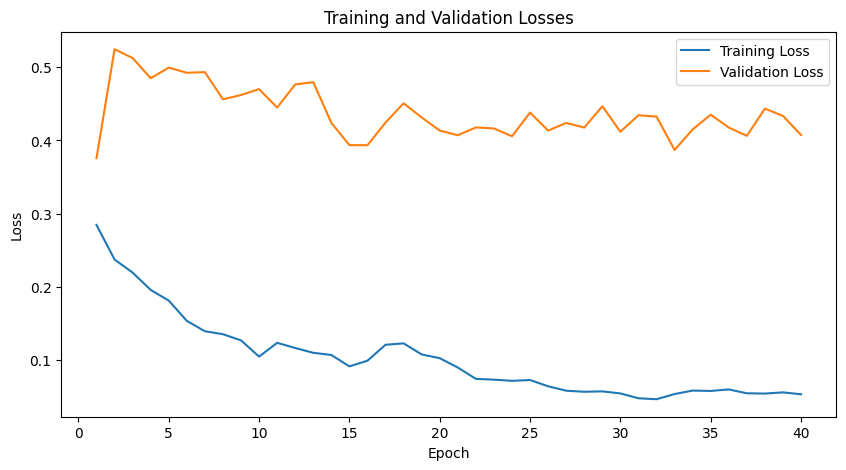

In [11]:
import wandb
import os
import matplotlib.pyplot as plt

# Enable CUDA launch blocking
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Initialize wandb
wandb.init(project="bone-fracture-detection")

# Define the optimizer and the learning rate scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
grad_scaler = torch.amp.GradScaler(enabled=True)
# Training loop
num_epochs = 40
train_losses = []
val_ious = []

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    with tqdm(total=len(train_dataloader.dataset), desc=f'Epoch {epoch}/{num_epochs}', unit='img') as pbar:
        for batch in train_dataloader:
            images, targets = batch
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Filter out empty targets and invalid bounding boxes
            filtered_images, filtered_targets = [], []
            for img, tgt in zip(images, targets):
                valid_boxes = tgt["boxes"][(tgt["boxes"][:, 2] > tgt["boxes"][:, 0]) & (tgt["boxes"][:, 3] > tgt["boxes"][:, 1])]
                if valid_boxes.size(0) > 0:
                    tgt["boxes"] = valid_boxes
                    filtered_images.append(img)
                    filtered_targets.append(tgt)

            if len(filtered_images) == 0:
                continue

            optimizer.zero_grad()
            with torch.autocast(device if device == 'cuda' else 'cpu', enabled=True):
                loss_dict = model(filtered_images, filtered_targets)
                if not isinstance(loss_dict, dict):
                    raise ValueError(f"Expected loss_dict to be a dict, got {type(loss_dict)}")
                losses = sum(loss for loss in loss_dict.values())

            grad_scaler.scale(losses).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.5)
            running_loss += losses.item()
            grad_scaler.step(optimizer)
            grad_scaler.update()
            pbar.update(len(images))
            pbar.set_postfix(**{'loss (batch)': losses.item()})
    
    train_losses.append(running_loss / len(train_dataloader))
    
    avg_iou, all_iou_scores = evaluate_bounding_boxes_with_classes(model, eval_dataloader, device)
    val_ious.append(avg_iou)
    print(f'Average IoU: {avg_iou:.4f}')
    # Save the model if the IoU is better than the previous best
    if epoch == 1 or avg_iou > max(val_ious[:-1], default=0):
        torch.save(model.state_dict(), f"fasterrcnn_epoch_{epoch}.pth")
        print(f"Model saved at epoch {epoch} with IoU: {avg_iou:.4f}")

    # Log the loss to wandb
    wandb.log({"epoch": epoch, "loss": running_loss / len(train_dataloader)})

    # Log the loss to wandb
    wandb.log({"epoch": epoch, "val_iou": avg_iou})

    print(f"Epoch [{epoch}/{num_epochs}], Loss: {running_loss / len(train_dataloader):.4f}")

# # Save the model checkpoint
# torch.save(model.state_dict(), "mask_rcnn_bone_fracture.pth")

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
if val_ious:  # Check if val_losses is not empty
    plt.plot(range(1, len(val_ious) + 1), val_ious, label='Validation Loss')
else:
    print("Validation losses are empty. Skipping validation loss plot.")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

In [15]:
# Load the model checkpoint
checkpoint_path = "maskrcnn_epoch_72.pth"
model.load_state_dict(torch.load(checkpoint_path))
 # Set the model to evaluation mode

<All keys matched successfully>

In [12]:
test_image_dir = '/home/mp/.cache/kagglehub/datasets/pkdarabi/bone-fracture-detection-computer-vision-project/versions/2/bone fracture detection.v4-v4.yolov8/test/images'
test_label_dir = '/home/mp/.cache/kagglehub/datasets/pkdarabi/bone-fracture-detection-computer-vision-project/versions/2/bone fracture detection.v4-v4.yolov8/test/labels'

test_dataset = BoneFractureDataset(image_dir=test_image_dir, label_dir=test_label_dir, transform=transform)

In [12]:
# test_image_dir = '/home/mp/.cache/kagglehub/datasets/pkdarabi/bone-fracture-detection-computer-vision-project/versions/2/bone fracture detection.v4-v4.yolov8/valid/images'
# test_label_dir = '/home/mp/.cache/kagglehub/datasets/pkdarabi/bone-fracture-detection-computer-vision-project/versions/2/bone fracture detection.v4-v4.yolov8/valid/labels'

# test_dataset = BoneFractureDataset(image_dir=test_image_dir, label_dir=test_label_dir, transform=transform)

In [18]:
from torchvision.ops import box_iou
def compute_test_accuracy(model, dataloader, device):
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc='Computing Test Accuracy', unit='batch'):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for target, output in zip(targets, outputs):
                gt_boxes = target['boxes']
                gt_labels = target['labels']
                pred_boxes = output['boxes']
                pred_labels = output['labels']

                if len(gt_boxes) == 0 or len(pred_boxes) == 0:
                    continue

                for gt_box, gt_label in zip(gt_boxes, gt_labels):
                    matching_indices = (pred_labels == gt_label).nonzero(as_tuple=True)[0]
                    if len(matching_indices) > 0:
                        matching_pred_boxes = pred_boxes[matching_indices]
                        iou_scores = box_iou(gt_box.unsqueeze(0), matching_pred_boxes)
                        max_iou_score = iou_scores.max().item()
                        if max_iou_score >= 0.3:  # IoU threshold for correct prediction
                            correct_predictions += 1
                        total_predictions += 1

    accuracy = (correct_predictions / total_predictions) * 100 if total_predictions > 0 else 0
    return accuracy
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn)
# Compute test accuracy
test_accuracy = compute_test_accuracy(model, test_dataloader, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")




Computing Test Accuracy: 100%|██████████| 22/22 [00:04<00:00,  4.77batch/s]

Test Accuracy: 56.14%


Computing Confusion Matrix: 100%|██████████| 22/22 [00:04<00:00,  4.76batch/s]


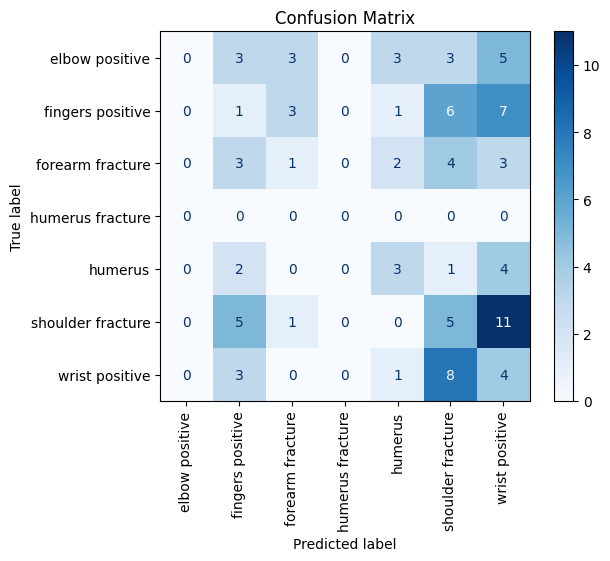

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def compute_confusion_matrix(model, dataloader, device, num_classes):
    """
    Compute the confusion matrix for the test dataset.

    Args:
        model: The trained model.
        dataloader: DataLoader for the test dataset.
        device: Device to run the evaluation on (e.g., 'cuda' or 'cpu').
        num_classes: Number of classes in the dataset.

    Returns:
        confusion_matrix: The confusion matrix as a numpy array.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc='Computing Confusion Matrix', unit='batch'):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for target, output in zip(targets, outputs):
                gt_labels = target['labels'].cpu().numpy()
                pred_labels = output['labels'].cpu().numpy() if 'labels' in output else np.array([])

                all_labels.extend(gt_labels)
                all_preds.extend(pred_labels)

    # Ensure all_preds and all_labels are the same length
    min_length = min(len(all_labels), len(all_preds))
    all_labels = np.array(all_labels[:min_length])
    all_preds = np.array(all_preds[:min_length])

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
    return cm

# Compute the confusion matrix
cm = compute_confusion_matrix(model, test_dataloader, device, num_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

In [1]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

20

In [16]:

import os
import pandas as pd
import cv2
import time
from glob import glob
from tqdm import tqdm
import numpy as np 
import cv2 as cv
import zipfile
import io
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
from sklearn.impute import SimpleImputer
import albumentations
from sklearn.model_selection import train_test_split
from scipy.ndimage.morphology import binary_dilation
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
from pathlib import Path
import matplotlib.patches as patches
from PIL import Image

# You can use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass

warnings.warn = warn
warnings.filterwarnings('ignore')

label_names = ['elbow positive', 'fingers positive', 'forearm fracture', 'humerus fracture', 'humerus', 'shoulder fracture', 'wrist positive']

# eval dataset contains too many mistakes, will create and eval dataset by splitting the train dataset


import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
from glob import glob
from torchvision import tv_tensors
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define the augmentation pipeline
def get_augmentation_pipeline():
    return A.Compose([
        #A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5),
        #A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.5),
        #A.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05, p=0.5),
        #A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2),
        A.Normalize(mean=(0.5,), std=(0.5,)),
        ToTensorV2()],
        bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
    )

class BoneFractureDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_paths = sorted(glob(os.path.join(image_dir, '*.jpg')))
        self.label_paths = sorted(glob(os.path.join(label_dir, '*.txt')))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        #print('index:', idx)
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]

        image = Image.open(image_path).convert("RGB")
        original_width, original_height = image.size
        image = np.array(image)

        #print(f'Image shape before: {image.shape}')
        
        boxes = []
        labels = []

        with open(label_path, 'r') as file:
            for line in file:
                parts = line.strip().split()
                class_id = int(parts[0])
                coords = [float(x) for x in parts[1:]]
                #print(f'coords: {coords}')

                # Extract the x and y coordinates
                x_coords = coords[0::2]
                y_coords = coords[1::2]

                # Convert from normalized coordinates to pixel coordinates
                x_coords = [x * original_width for x in x_coords]
                y_coords = [y * original_height for y in y_coords]

                # Find the min and max coordinates to form the bounding box
                x_min = min(x_coords)
                y_min = min(y_coords)
                x_max = max(x_coords)
                y_max = max(y_coords)

                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(class_id)
        
        # Convert the bounding box coordinates to the format expected by the model

        boxes = np.array(boxes)
        
        if self.transform:
            augmented = self.transform(image=image, bboxes=boxes, labels=labels)
            image = augmented['image']
            boxes = augmented['bboxes']
            labels = augmented['labels']

            #print(f'Image shape after: {image.shape}')
            
            new_width, new_height = image.shape[2], image.shape[1]  # Get the new width and height from the transformed image

            # Scale the bounding boxes to the new image size
            scale_x = new_width / original_width
            scale_y = new_height / original_height
            boxes = [[x_min * scale_x, y_min * scale_y, x_max * scale_x, y_max * scale_y] for x_min, y_min, x_max, y_max in boxes]
        
        if len(boxes) == 0:
            # If there are no bounding boxes, create an empty tensor
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)

        if len(labels) > len(boxes):
            labels = labels[:len(boxes)]


        boxes = torch.tensor(boxes, dtype=torch.float32)
 
        labels = torch.tensor(labels, dtype=torch.int64)

        image_id = torch.tensor([idx])

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) if len(boxes) > 0 else torch.tensor([0], dtype=torch.float32)
        if len(area) > len(boxes):
            area = area[:len(boxes)]

        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        return image, target


train_image_dir = '/home/mp/.cache/kagglehub/datasets/pkdarabi/bone-fracture-detection-computer-vision-project/versions/2/bone fracture detection.v4-v4.yolov8/train/images'
train_label_dir = '/home/mp/.cache/kagglehub/datasets/pkdarabi/bone-fracture-detection-computer-vision-project/versions/2/bone fracture detection.v4-v4.yolov8/train/labels'
transform = get_augmentation_pipeline()

# Split the dataset into train and eval sets
train_image_paths = sorted(glob(os.path.join(train_image_dir, '*.jpg')))
train_label_paths = sorted(glob(os.path.join(train_label_dir, '*.txt')))

# # Use train_test_split to split the paths
# train_image_paths, eval_image_paths, train_label_paths, eval_label_paths = train_test_split(
#     train_image_paths, train_label_paths, test_size=0.2, random_state=42
# )

# Create train and eval datasets
train_dataset = BoneFractureDataset(image_dir=train_image_dir, label_dir=train_label_dir, transform=transform)
train_dataset.image_paths = train_image_paths
train_dataset.label_paths = train_label_paths


import fiftyone as fo

import fiftyone.utils.coco as fouc

# Create a FiftyOne dataset
fo_dataset = fo.Dataset("bone_fracture_dataset11")

# Add samples to the dataset
for idx in range(len(train_dataset)):
    image, target = train_dataset[idx]
    image_path = train_dataset.image_paths[idx]
    
    # Convert bounding boxes to FiftyOne format
    detections = []
    for box, label in zip(target['boxes'], target['labels']):
        x_min, y_min, x_max, y_max = box.tolist()
        width = x_max - x_min
        height = y_max - y_min
        detections.append(
            fo.Detection(
                label=label_names[label.item()],
                bounding_box=[x_min / image.shape[2], y_min / image.shape[1], width / image.shape[2], height / image.shape[1]]
            )
        )
    
    # Create a FiftyOne sample
    sample = fo.Sample(filepath=image_path, ground_truth=fo.Detections(detections=detections))
    fo_dataset.add_sample(sample)

# Launch the FiftyOne app
session = fo.launch_app(fo_dataset)



